# Task 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import wandb

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [32]:
wandb.login()

True

In [ ]:
wandb.init(project="mlp-iris-classification-new", name="mlp-iris-experiment-new")

In [ ]:
data = load_iris()
X = data.data
y = data.target.reshape(-1, 1)

# Ohe Hot Encoding to convert the categorical variables into numerical
ohe = OneHotEncoder(sparse_output=False)
y_encoded = ohe.fit_transform(y)

# Normalizing the features(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert to PyTorch tensors, for training purposes
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.float32)

In [ ]:

dataset = TensorDataset(X_tensor, y_tensor)

# Splitting the dataset with 70% train, 10% val, 20% test
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
# Multi Layer Perceptron Model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

model = MLP()

In [ ]:
# Defining the hyperparameters--> Cross Entropy Loss as the loss function and Adam optimizer.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses = []
val_losses = []

for epoch in range(50):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 1.1410, Val Loss: 1.1516
Epoch 2, Train Loss: 1.1333, Val Loss: 1.1468
Epoch 3, Train Loss: 1.1242, Val Loss: 1.1421
Epoch 4, Train Loss: 1.1265, Val Loss: 1.1373
Epoch 5, Train Loss: 1.1100, Val Loss: 1.1323
Epoch 6, Train Loss: 1.1114, Val Loss: 1.1273
Epoch 7, Train Loss: 1.1052, Val Loss: 1.1222
Epoch 8, Train Loss: 1.0973, Val Loss: 1.1169
Epoch 9, Train Loss: 1.0955, Val Loss: 1.1114
Epoch 10, Train Loss: 1.0813, Val Loss: 1.1057
Epoch 11, Train Loss: 1.0773, Val Loss: 1.0999
Epoch 12, Train Loss: 1.0714, Val Loss: 1.0941
Epoch 13, Train Loss: 1.0662, Val Loss: 1.0880
Epoch 14, Train Loss: 1.0617, Val Loss: 1.0816
Epoch 15, Train Loss: 1.0479, Val Loss: 1.0746
Epoch 16, Train Loss: 1.0357, Val Loss: 1.0672
Epoch 17, Train Loss: 1.0299, Val Loss: 1.0596
Epoch 18, Train Loss: 1.0281, Val Loss: 1.0517
Epoch 19, Train Loss: 1.0190, Val Loss: 1.0438
Epoch 20, Train Loss: 1.0193, Val Loss: 1.0353
Epoch 21, Train Loss: 0.9943, Val Loss: 1.0263
Epoch 22, Train Loss: 

In [ ]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions = torch.argmax(outputs, dim=1).numpy()
        y_pred.extend(predictions)
        y_true.extend(torch.argmax(batch_y, dim=1).numpy())

accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred)

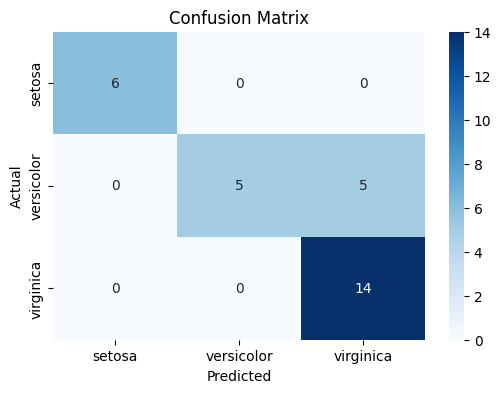

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig("Confusion_matrix.png")
plt.show()

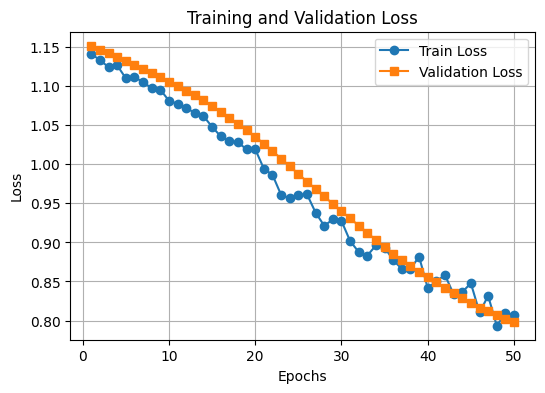

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, 51), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, 51), val_losses, label='Validation Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")
plt.show()

In [ ]:
table = wandb.Table(columns=["Layer", "Units", "Activation", "Optimizer"])

table.add_data("Input", 4, "N/A", "Adam")
table.add_data("Hidden", 16, "ReLU", "Adam")
table.add_data("Output", 3, "Softmax", "Adam")

wandb.log({
    "model_architecture": table,
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "loss_curve": wandb.Image("loss_curve.png"),
    "confusion_matrix": wandb.Image("Confusion_matrix.png")
})

Error: You must call wandb.init() before wandb.log()

In [ ]:
torch.save(model.state_dict(), "mlp_iris_model_6.pth")
wandb.finish()

**Weights and Biases Logging**

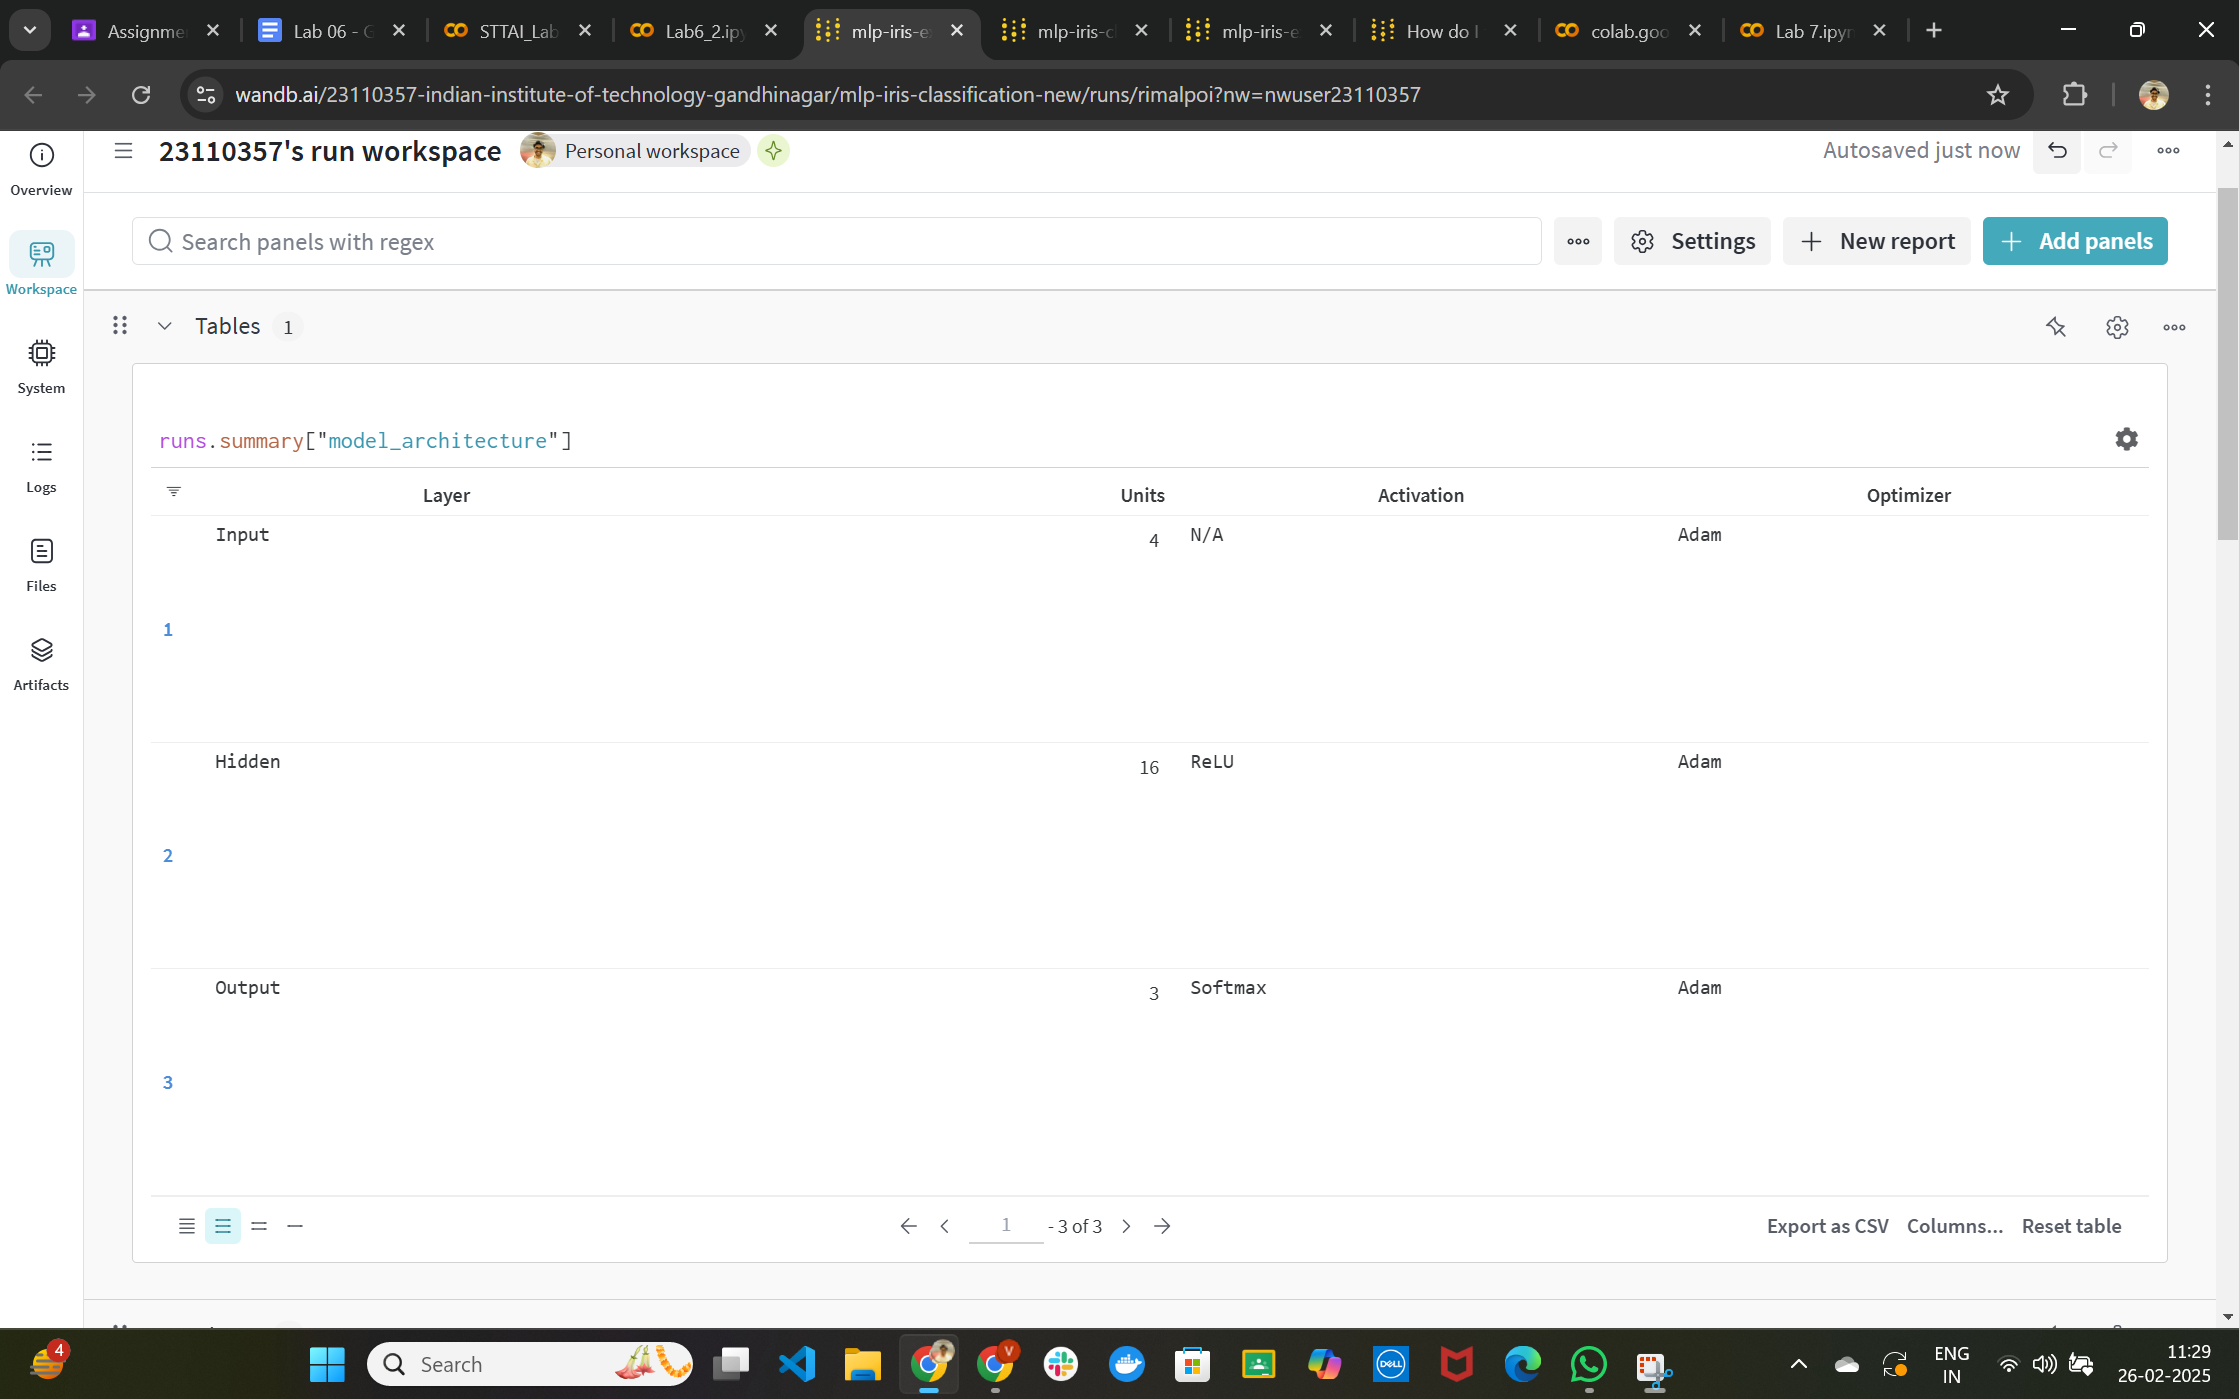

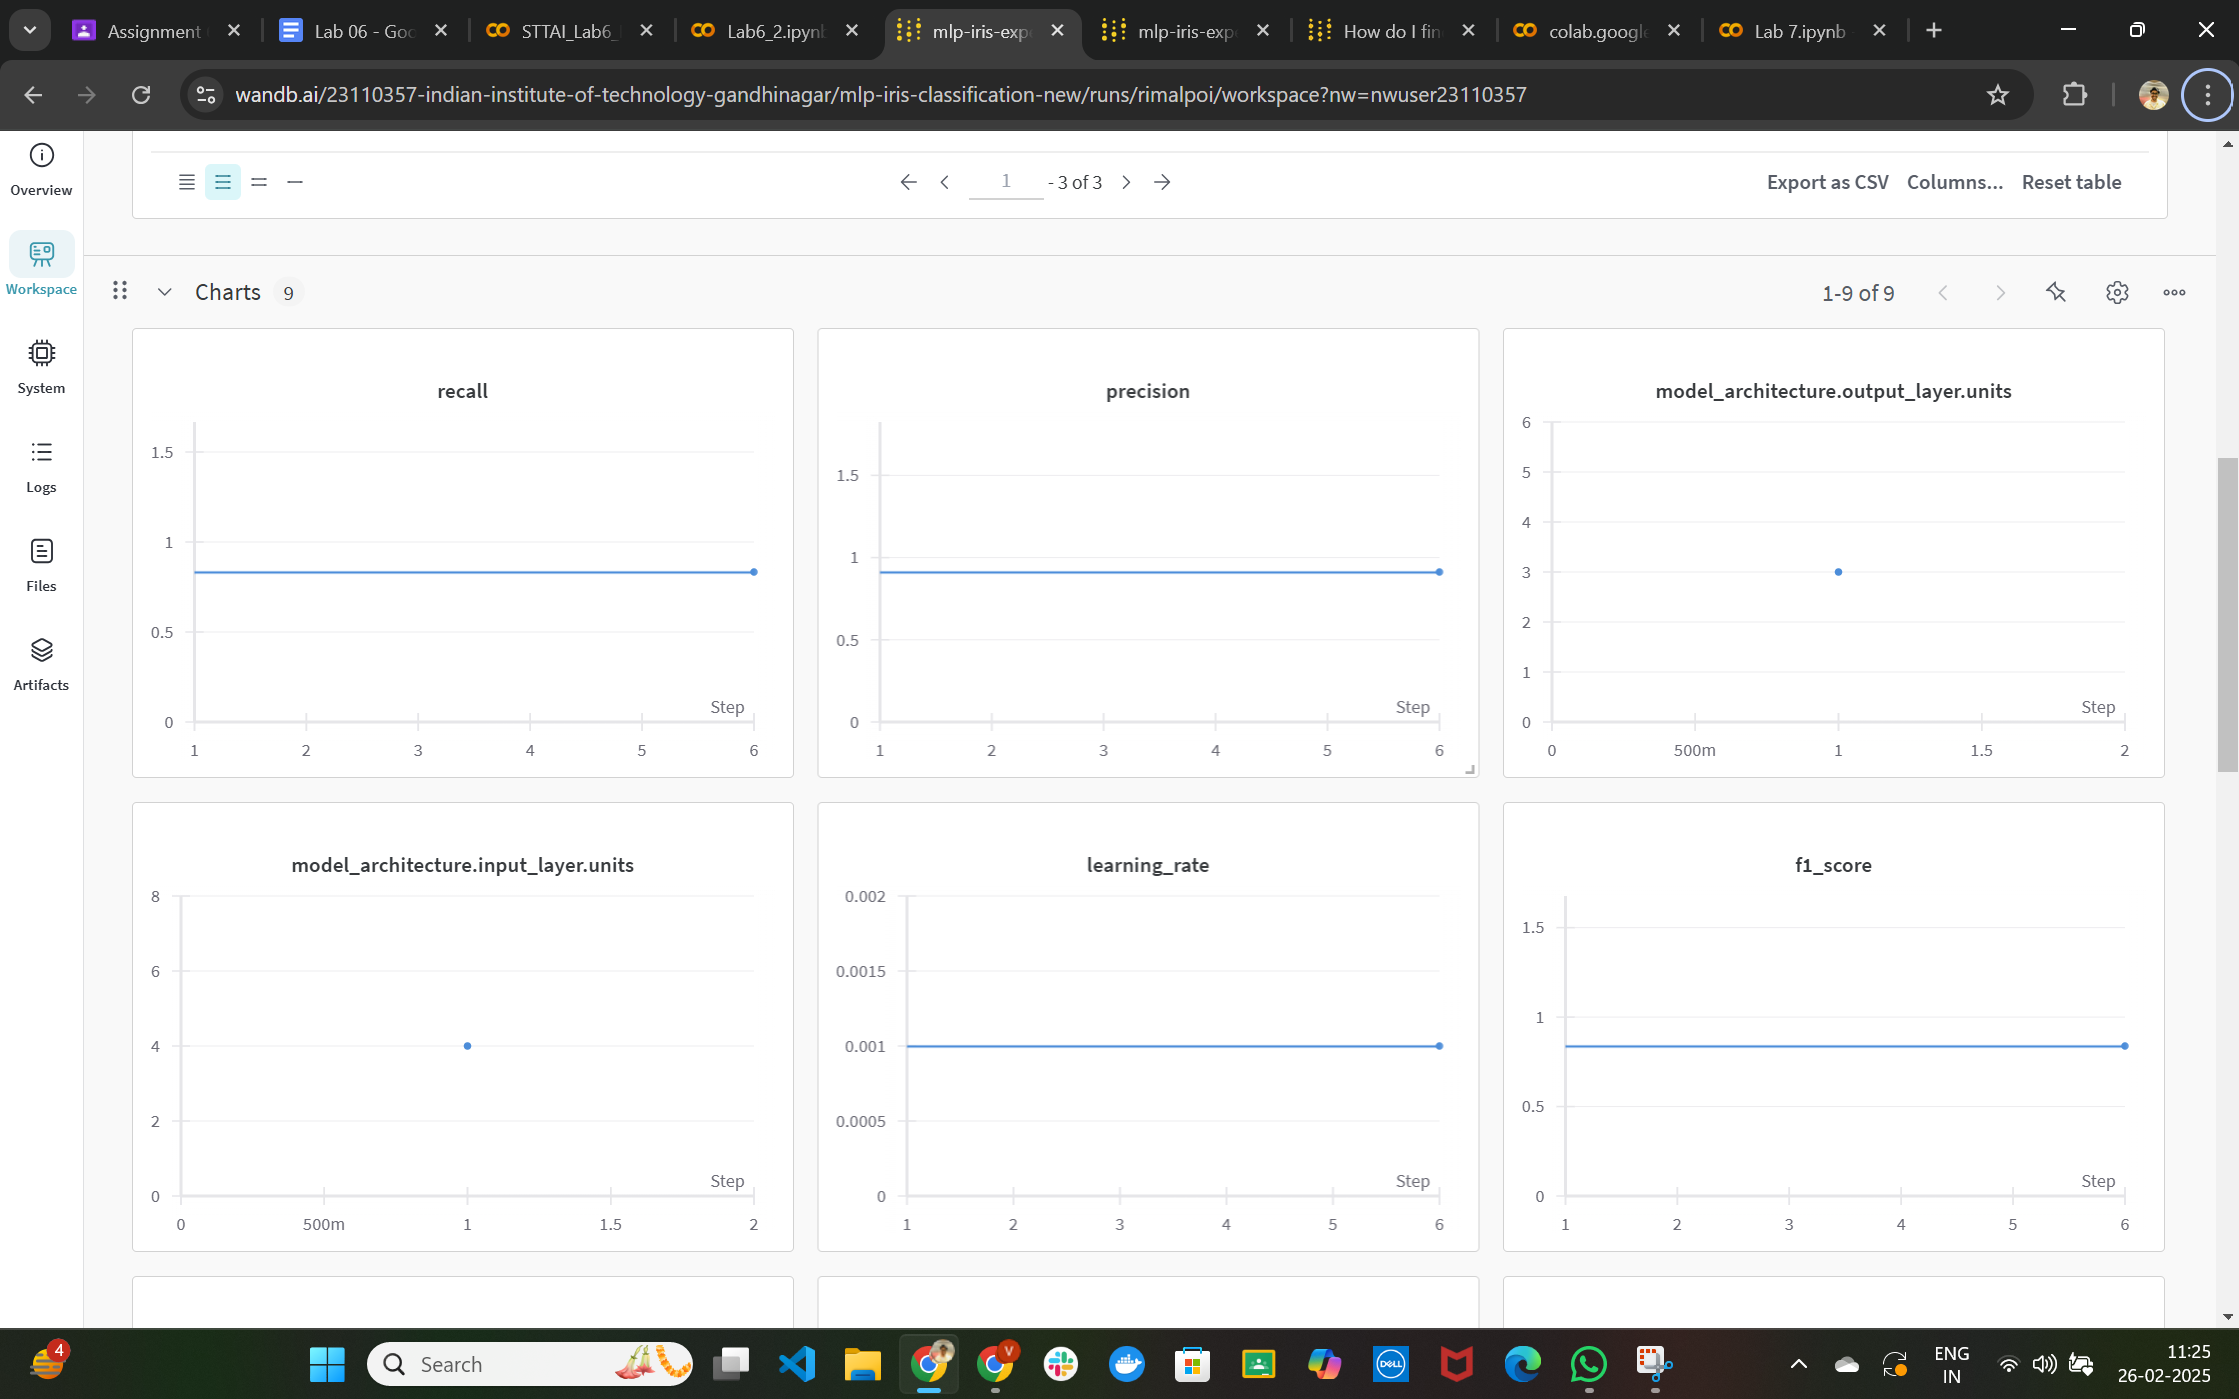

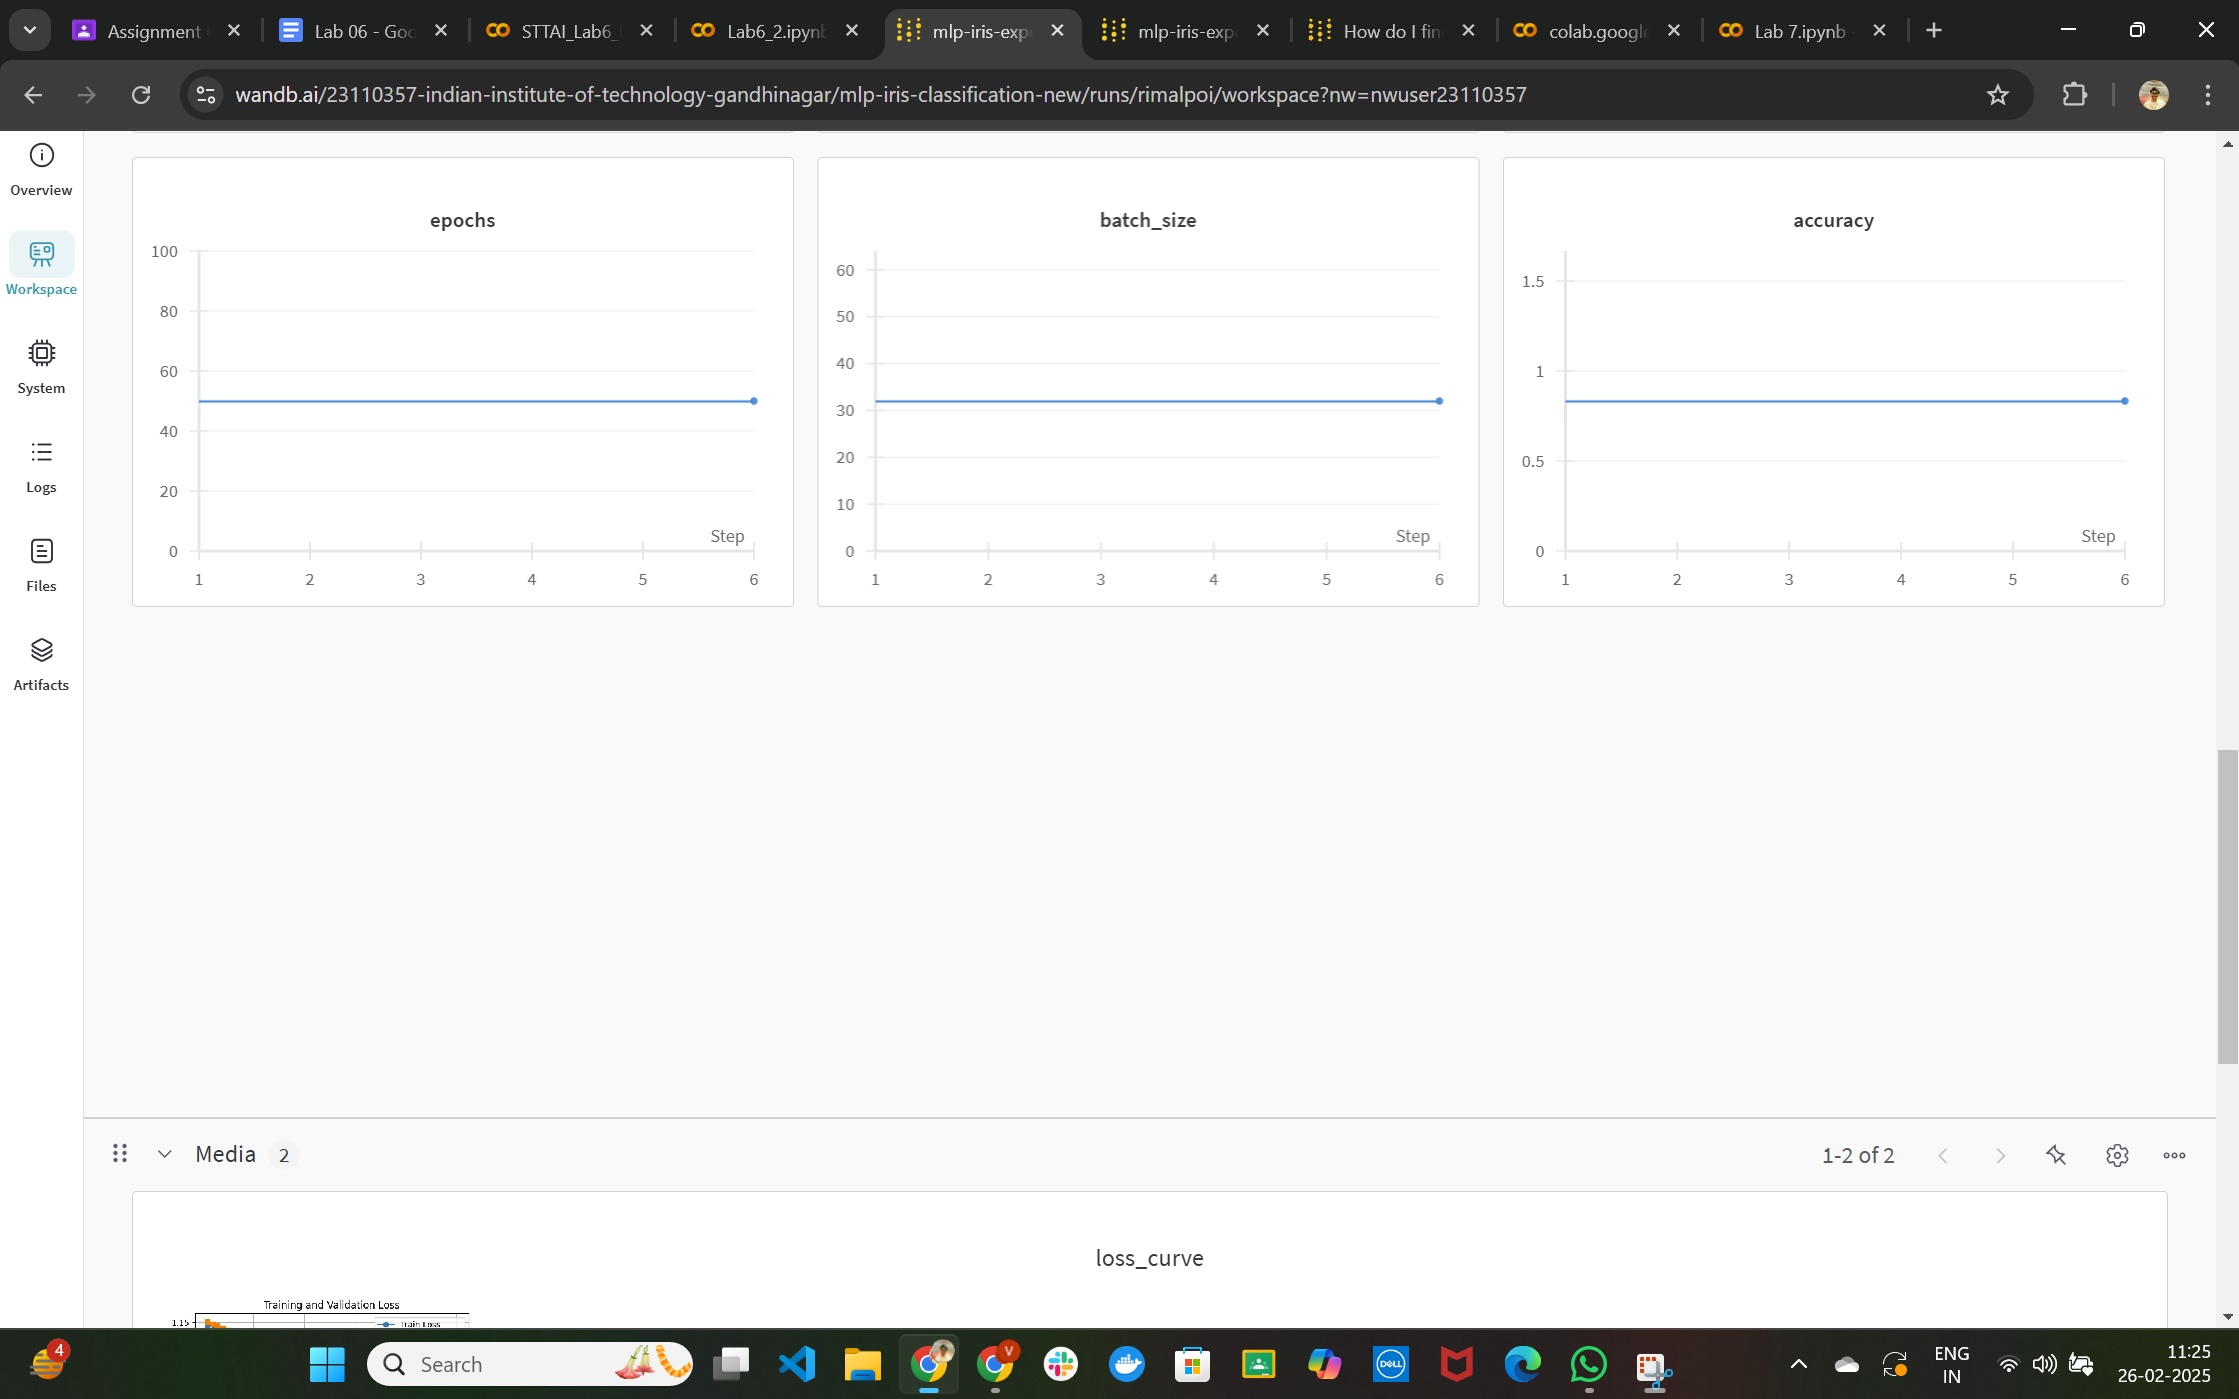

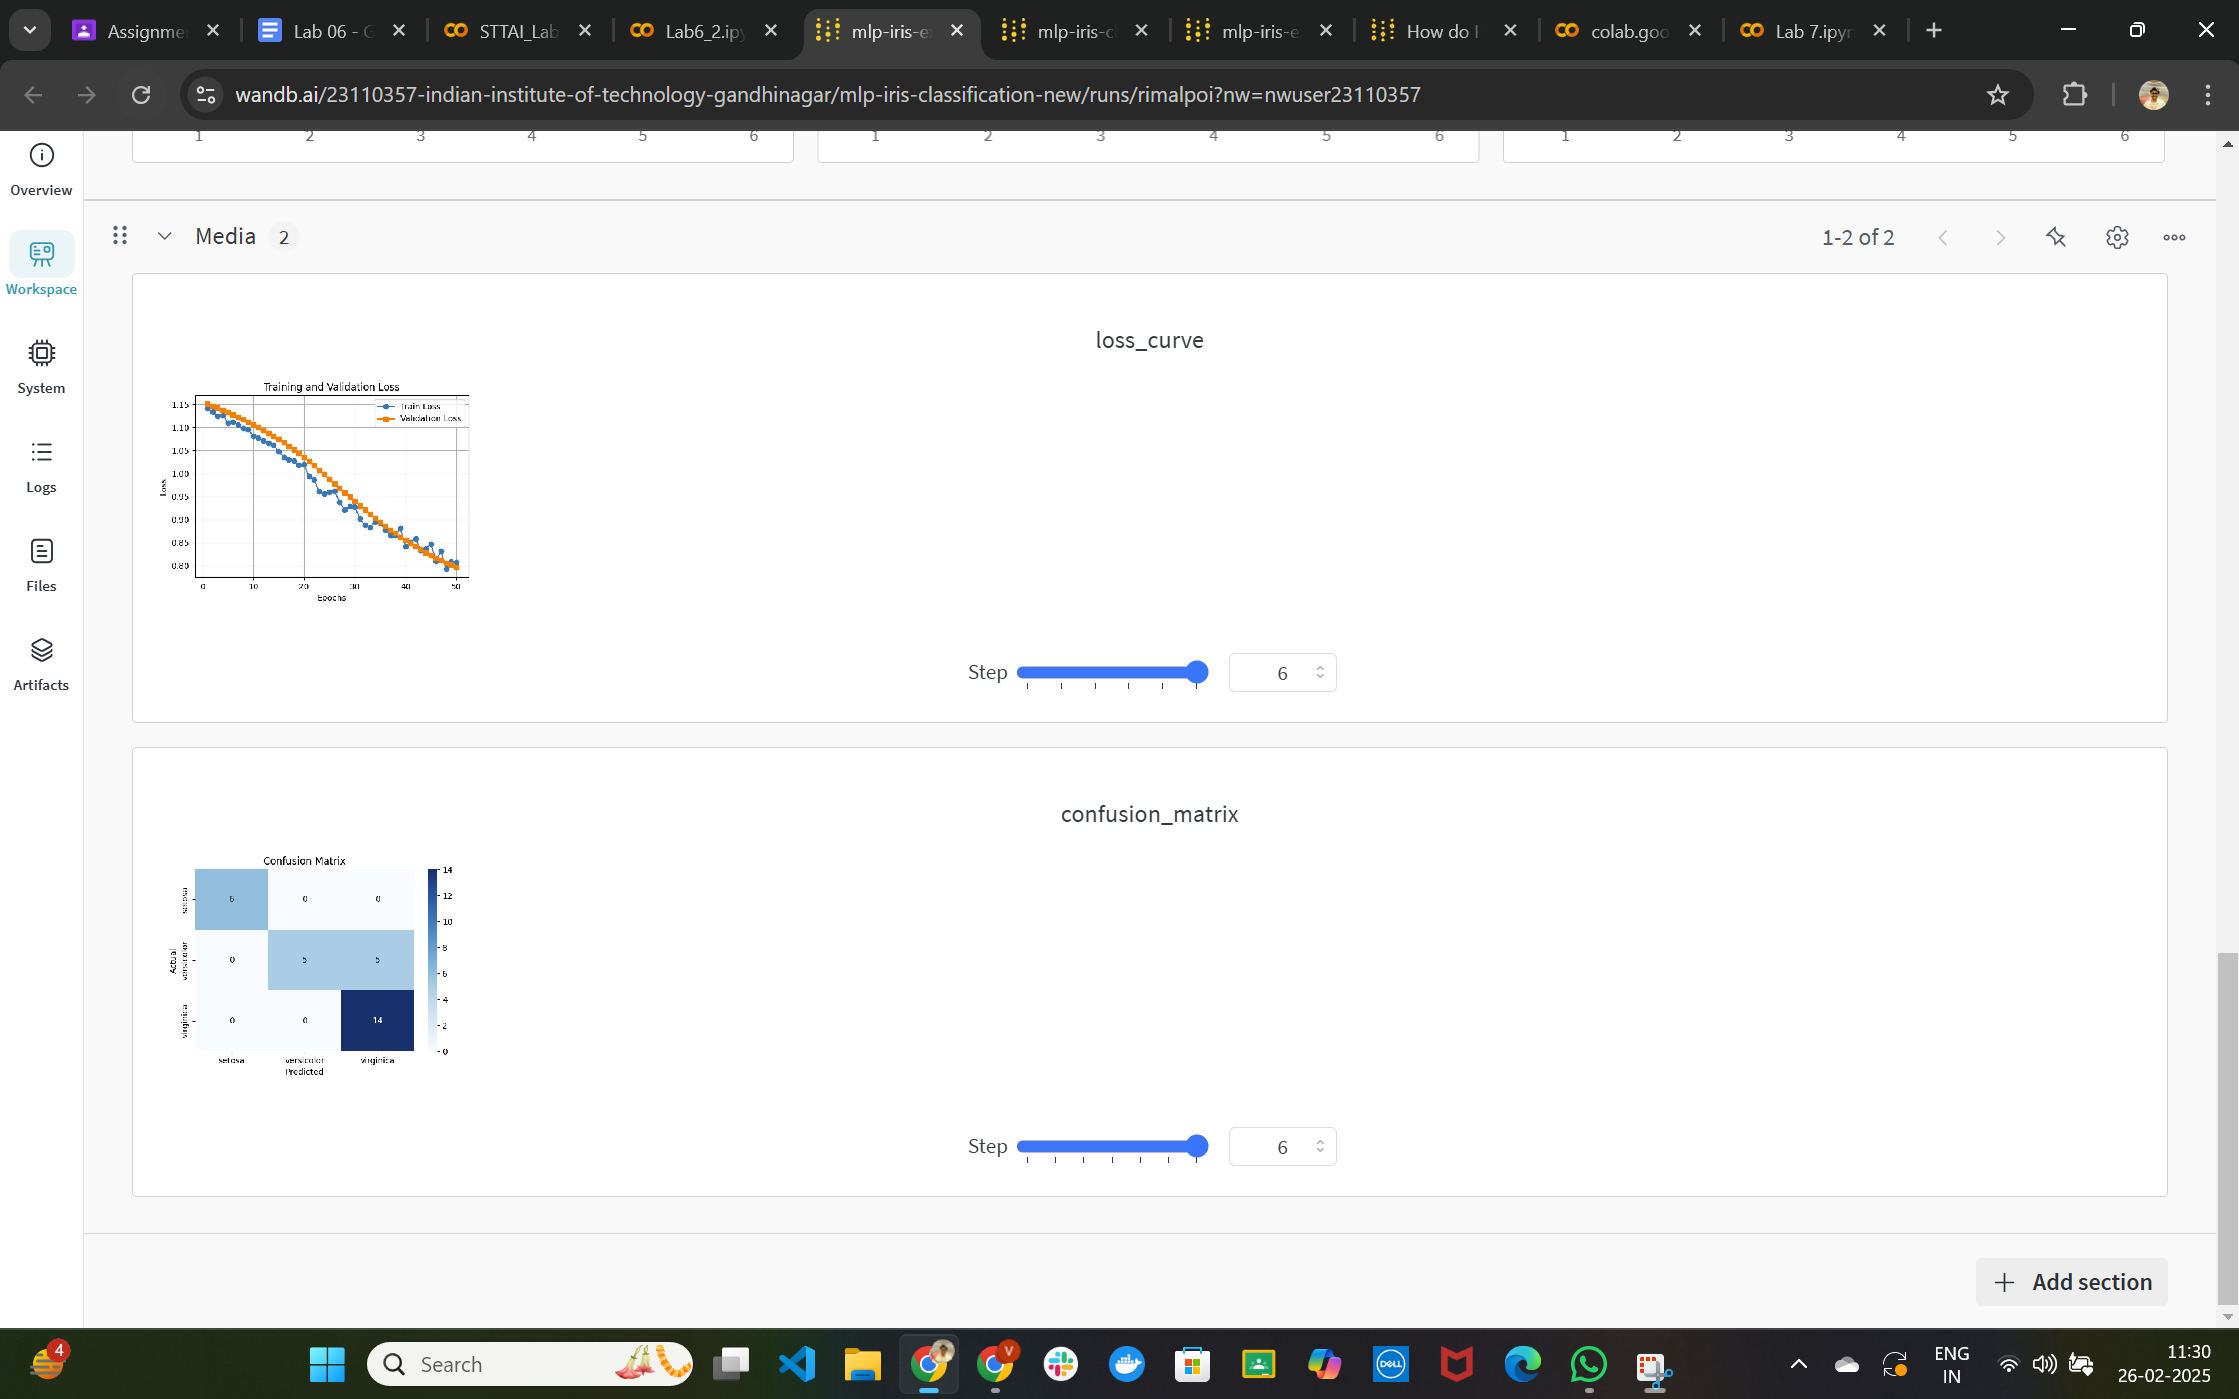

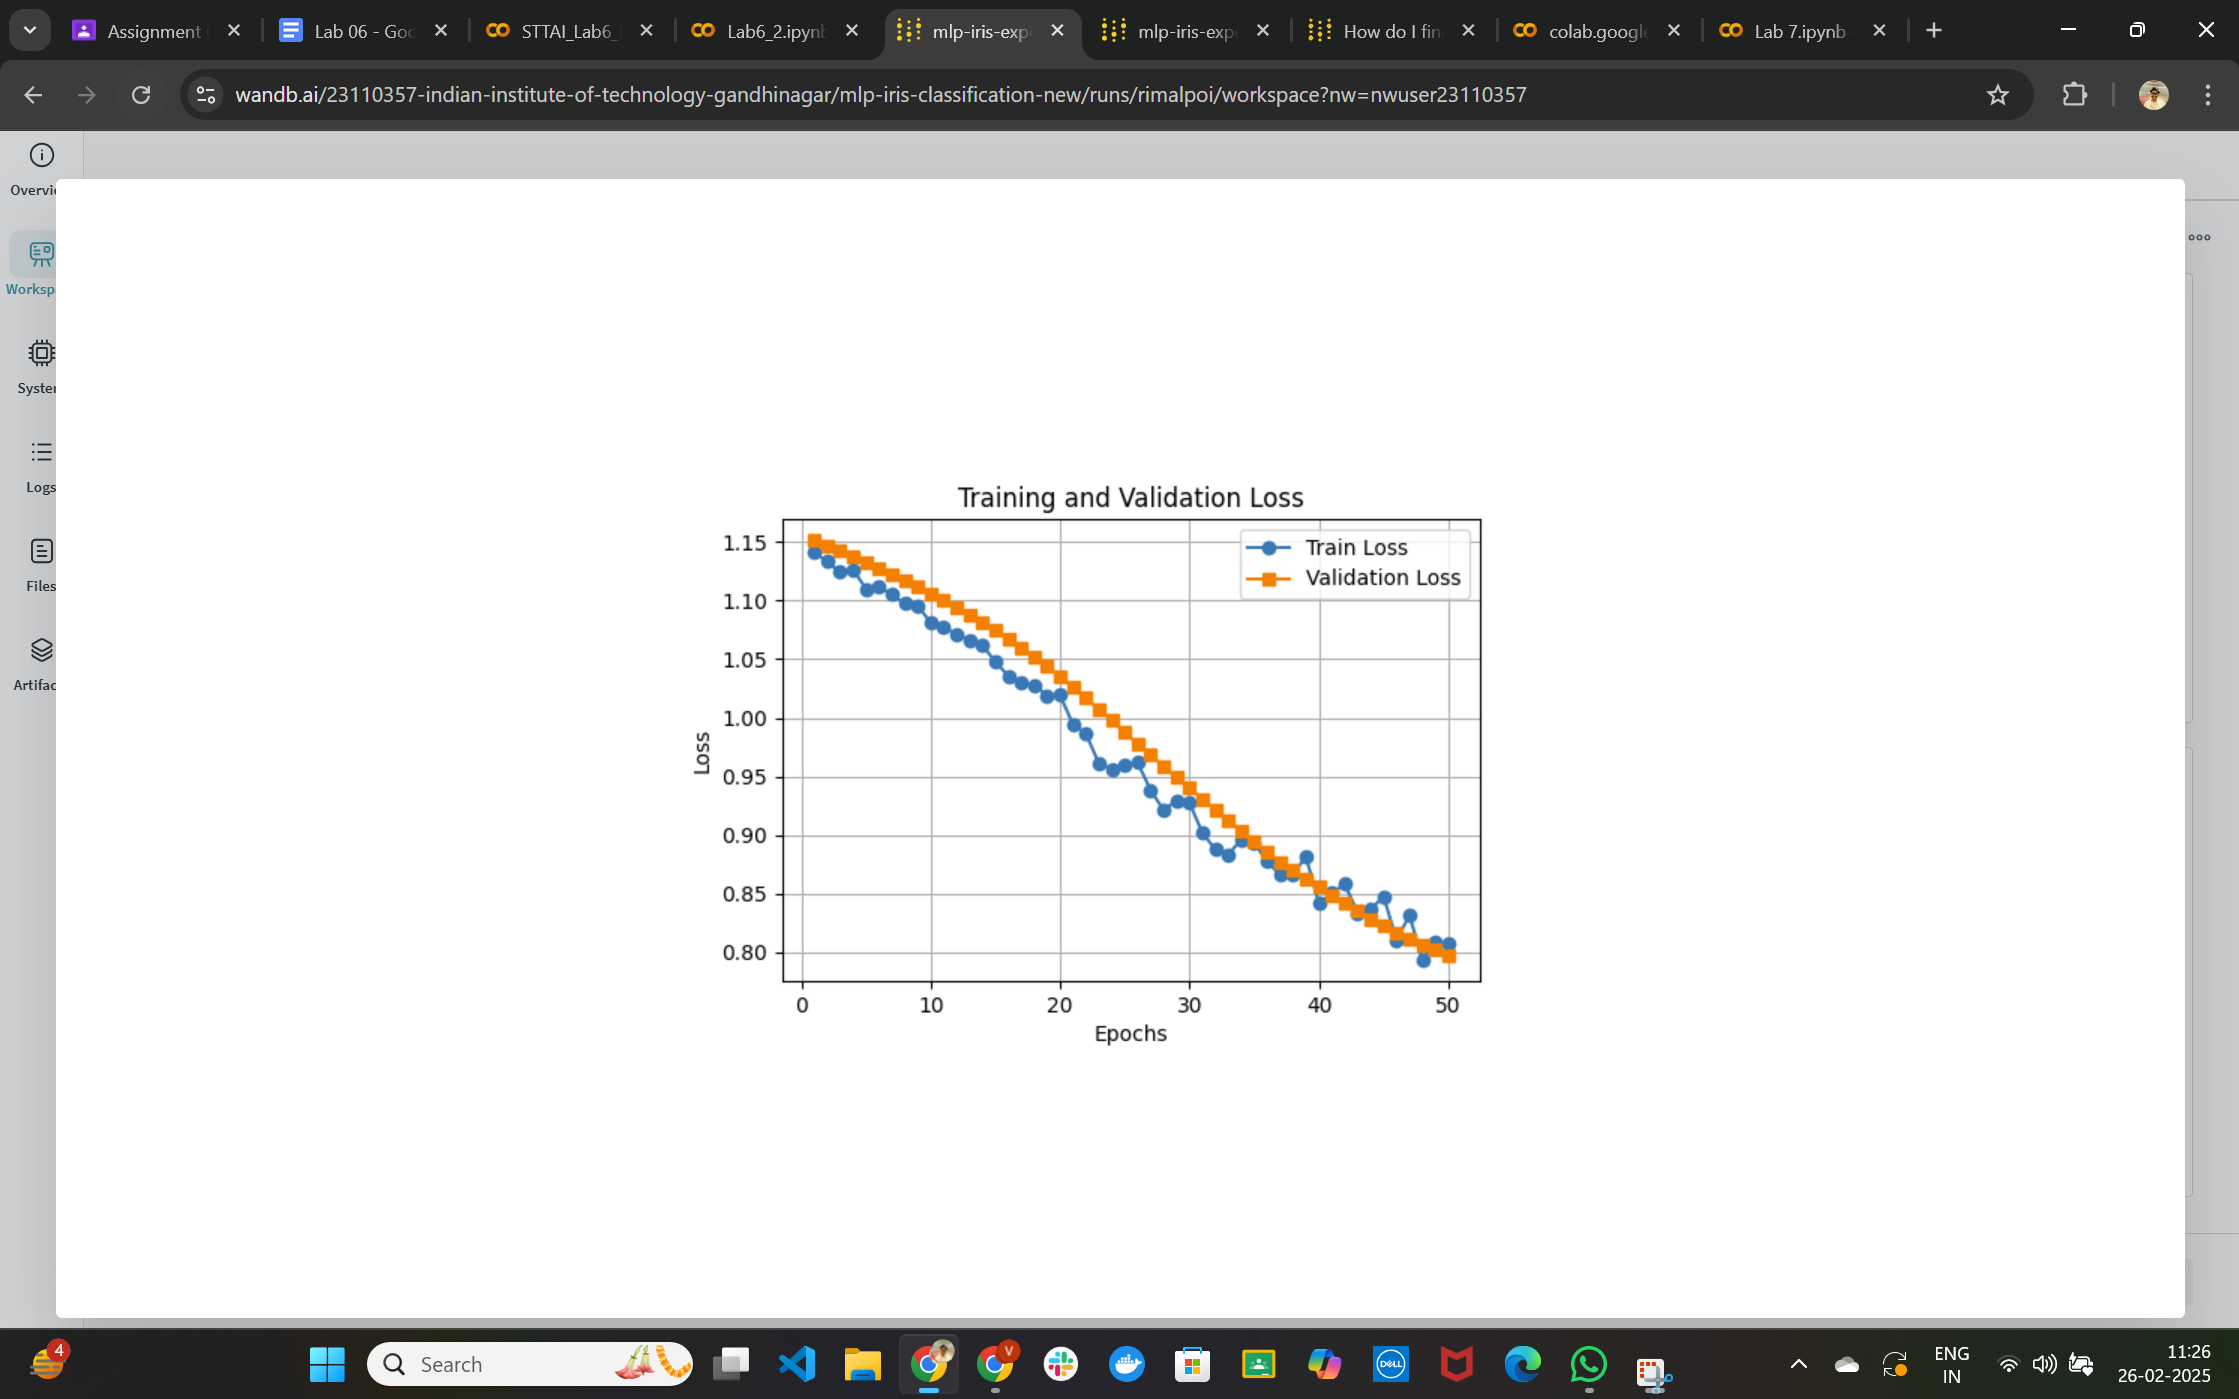

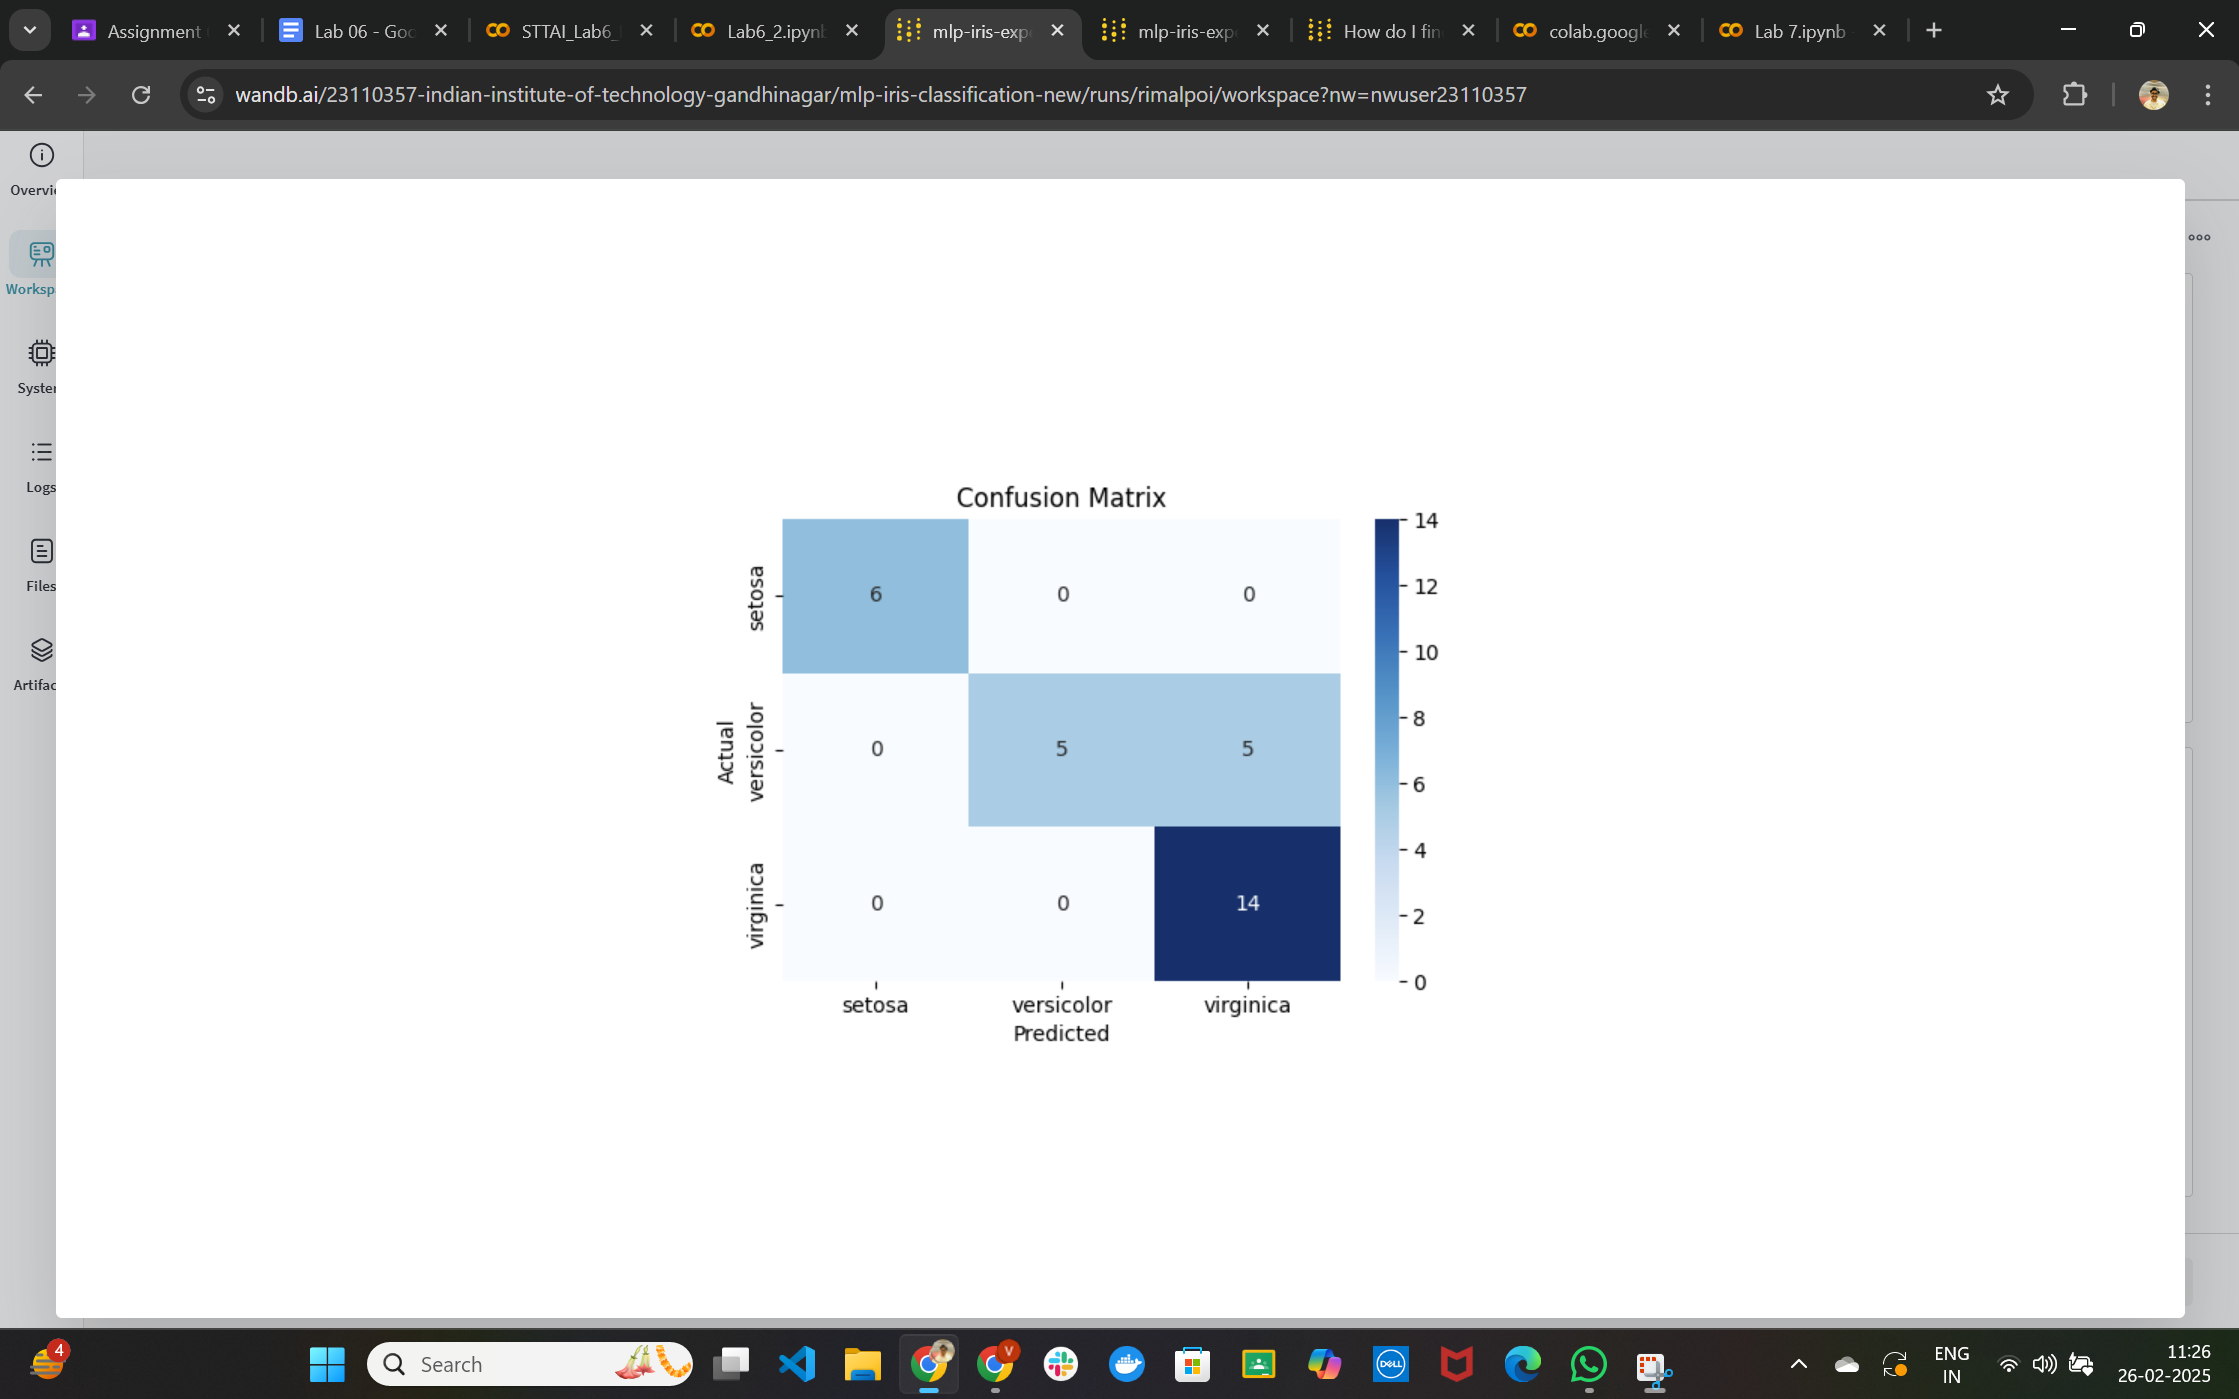

# TASK 2

In [ ]:
model
# This is the model we trained in our previous section

MLP(
  (fc1): Linear(in_features=4, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
# Creating the data loaders for batch size 2 and 4
train_loader_2 = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader_2 = DataLoader(val_dataset, batch_size=2)
test_loader_2 = DataLoader(test_dataset, batch_size=2)

train_loader_4 = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader_4 = DataLoader(val_dataset, batch_size=4)
test_loader_4 = DataLoader(test_dataset, batch_size=4)

In [ ]:
learning_rates = [1e-3, 1e-5]
epochs = [1, 3, 5]

In [ ]:
import copy
initial_state = copy.deepcopy(model.state_dict())

In [ ]:
initial_state
# we are storing the weights of the model initially

OrderedDict([('fc1.weight',
              tensor([[-0.5411,  0.2797, -0.3676, -0.2078],
                      [-0.2935,  0.3970, -0.2850,  0.3538],
                      [ 0.0086,  0.3335, -0.4451,  0.2784],
                      [-0.0685,  0.2661, -0.6363,  0.0120],
                      [ 0.1231, -0.1791,  0.6689,  0.3662],
                      [-0.4320, -0.0686, -0.2056,  0.0914],
                      [-0.3029, -0.0856, -0.3629, -0.5648],
                      [-0.0377,  0.5812, -0.6842, -0.0975],
                      [ 0.4078, -0.1241,  0.0429,  0.4786],
                      [ 0.4537,  0.1323,  0.1054,  0.0709],
                      [ 0.2568, -0.0935,  0.0936,  0.5749],
                      [ 0.6521, -0.0269,  0.1370,  0.2668],
                      [ 0.0509,  0.2563,  0.2050, -0.3669],
                      [-0.0436,  0.2910,  0.3461,  0.1346],
                      [-0.2354, -0.4275, -0.3770, -0.1167],
                      [-0.0232,  0.4729,  0.0183, -0.6596]])),
         

In [ ]:
def train_model(model, trainLoader):
    model.train()
    for batch_X, batch_y in trainLoader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

In [ ]:
def test_model(model, testLoader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch_X, batch_y in testLoader:
            outputs = model(batch_X)
            predictions = torch.argmax(outputs, dim=1).numpy()
            y_pred.extend(predictions)
            y_true.extend(torch.argmax(batch_y, dim=1).numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, cm

In [ ]:
epochs = [1, 2, 4]
learning_rates = [1e-3, 1e-5]

Learning Rate: 0.001, Epochs: 1, Batch Size: 2
Accuracy: 0.8333, Precision: 0.8739, Recall: 0.8429, F1: 0.8482


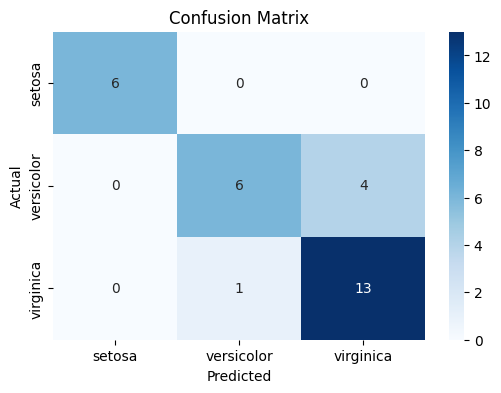

Learning Rate: 0.001, Epochs: 2, Batch Size: 2
Accuracy: 0.8000, Precision: 0.8519, Recall: 0.8095, F1: 0.8125


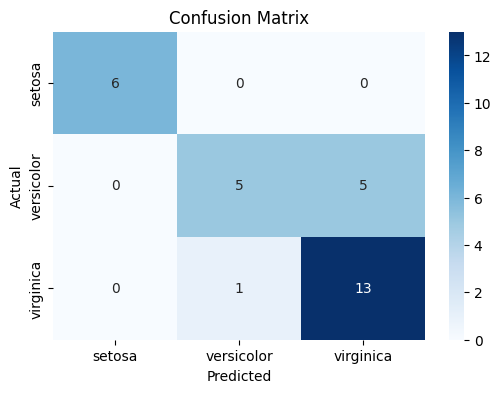

Learning Rate: 0.001, Epochs: 4, Batch Size: 2
Accuracy: 0.8333, Precision: 0.8739, Recall: 0.8429, F1: 0.8482


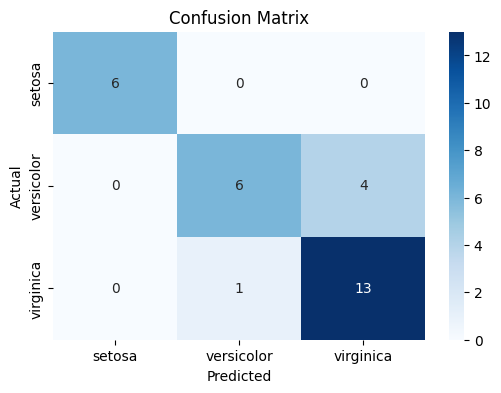

Learning Rate: 1e-05, Epochs: 1, Batch Size: 2
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


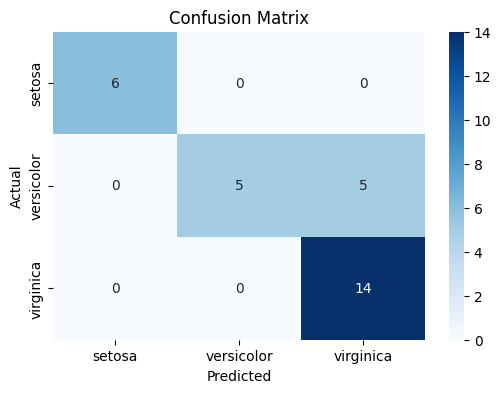

Learning Rate: 1e-05, Epochs: 2, Batch Size: 2
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


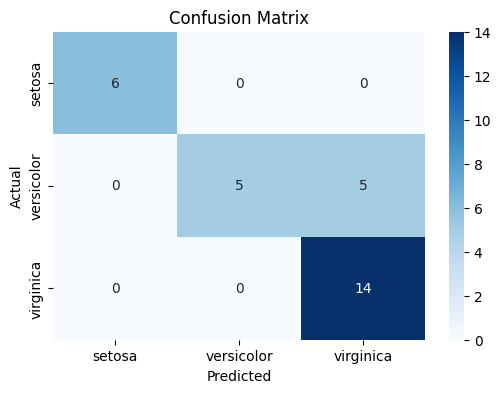

Learning Rate: 1e-05, Epochs: 4, Batch Size: 2
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


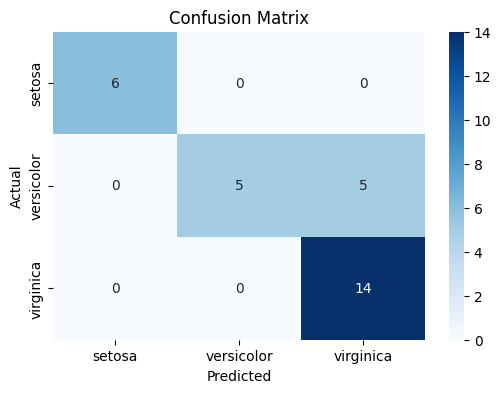

In [ ]:
for lr in learning_rates:
  for epoch in epochs:
      model.load_state_dict(copy.deepcopy(initial_state))  # Reset model to original state
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=lr)
      for i in range(epoch):

        train_model(model, train_loader_2)
      accuracy, precision, recall, f1, cm = test_model(model, test_loader_2)
      print(f"Learning Rate: {lr}, Epochs: {epoch}, Batch Size: 2")
      print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
      plt.figure(figsize=(6, 4))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.title("Confusion Matrix")
      plt.show()

Learning Rate: 0.001, Epochs: 1, Batch Size: 4
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


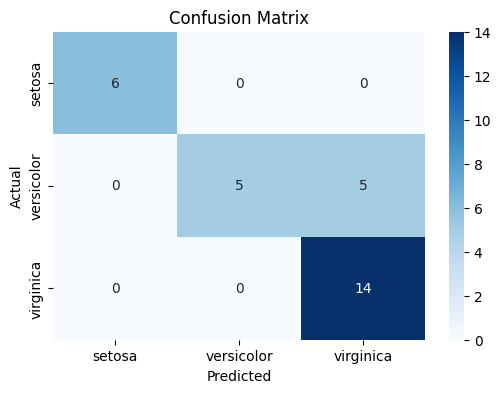

Learning Rate: 0.001, Epochs: 2, Batch Size: 4
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


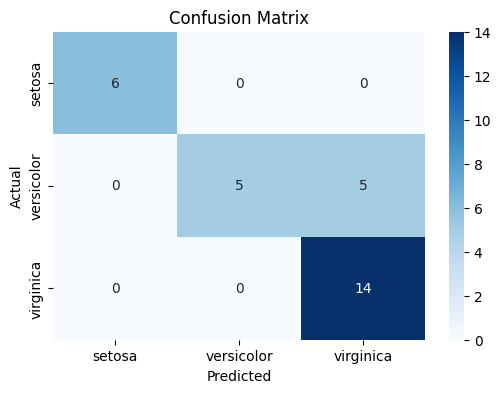

Learning Rate: 0.001, Epochs: 4, Batch Size: 4
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


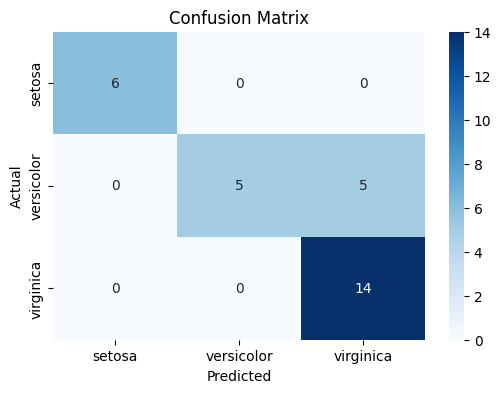

Learning Rate: 1e-05, Epochs: 1, Batch Size: 4
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


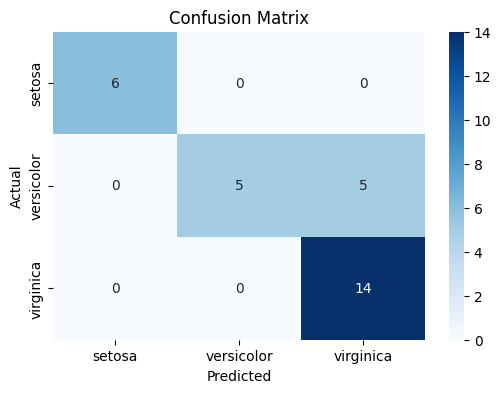

Learning Rate: 1e-05, Epochs: 2, Batch Size: 4
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


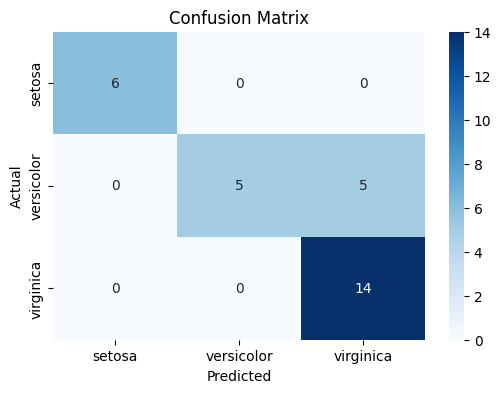

Learning Rate: 1e-05, Epochs: 4, Batch Size: 4
Accuracy: 0.8333, Precision: 0.9123, Recall: 0.8333, F1: 0.8384


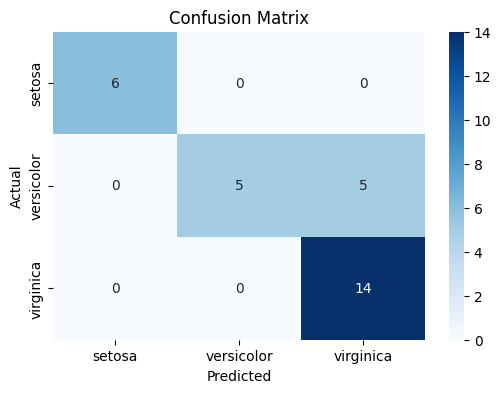

In [ ]:
for lr in learning_rates:
  for epoch in epochs:
      model.load_state_dict(copy.deepcopy(initial_state))  # Reset model to original state
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=lr)
      for i in range(epoch):

        train_model(model, train_loader_4)
      accuracy, precision, recall, f1, cm = test_model(model, test_loader_4)
      print(f"Learning Rate: {lr}, Epochs: {epoch}, Batch Size: 4")
      print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
      plt.figure(figsize=(6, 4))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
      plt.xlabel("Predicted")
      plt.ylabel("Actual")
      plt.title("Confusion Matrix")
      plt.show()

In [ ]:
def predict_sample(model, test_dataset, class_names, idx = 1):
    model.eval()
    sample, label = test_dataset[idx]
    true_label = torch.argmax(label).item()
    print(f"Input Features: {sample}")
    sample = sample.unsqueeze(0)
    with torch.no_grad():
        output = model(sample)
        predicted_class = torch.argmax(output).item()
        print(f"Predicted Class: {class_names[predicted_class]}")
        print(f"True Class: {class_names[true_label]}")
        print("-" * 50)

In [ ]:
class_names = ["Setosa", "Versicolor", "Virginica"]

In [ ]:
for id in range(5):
  predict_sample(model, test_dataset, class_names, id)

Input Features: tensor([ 0.5533, -1.2830,  0.6491,  0.3958])
Predicted Class: Virginica
True Class: Versicolor
--------------------------------------------------
Input Features: tensor([1.2803, 0.0982, 0.9333, 1.1856])
Predicted Class: Virginica
True Class: Virginica
--------------------------------------------------
Input Features: tensor([2.4920, 1.7096, 1.5016, 1.0539])
Predicted Class: Virginica
True Class: Virginica
--------------------------------------------------
Input Features: tensor([-1.0218, -2.4339, -0.1466, -0.2624])
Predicted Class: Versicolor
True Class: Versicolor
--------------------------------------------------
Input Features: tensor([1.0380, 0.0982, 0.3649, 0.2641])
Predicted Class: Virginica
True Class: Versicolor
--------------------------------------------------


In [ ]:
!pip install autogluon

In [ ]:
import autogluon.common as ag
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

